# Bias-correction for weather forecasts

We will use IBM PAIRS to study and correct biases in the GFS forecast. In detail, we will compare the temperature forecast made by NOAA's GFS with the ERA5 reanalysis. Aggregating 5 years worth of data will give evidence of a systematic yet location-dependent bias in the GFS data. We will then use PAIRS to remove these biases from the GFS forecast, leading to an MAE reduction of roughly 50%.

For details regarding both data layers, consult the PAIRS data explorer at https://ibmpairs.mybluemix.net/data-explorer. The layer IDs are
- 49423 (ERA5)
- 50195 (GFS)

In [5]:
from datetime import datetime, timedelta
import os, numpy as np, pandas as pd, logging
from matplotlib import pyplot as plt
from ibmpairs import paw, authentication

We set some auxiliary variables and configure the logging system. E.g. `iso8601` helps when converting datetime objects to strings in ISO 8601-compliant format.

In [4]:
oneSec = timedelta(seconds=1)
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

logging.basicConfig(level=logging.WARNING)
pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.ERROR)

We use our API key to authenticate. To do so, we generate an authentication object `pairs_credentials`. When using the `paw` library, this can be used directly when instantiating a query via `paw.PAIRSQuery`. However, when submitting an API request directly (via e.g. python's `requests` module), we need to use a suitable HTTP header. We construct this directly as well. See `pairs_auth_headers`.

**Please replace `<YOUR-PAIRS-API-KEY>` with your PAIRS API key.**

In [6]:
pairs_api_key = '<YOUR-PAIRS-API-KEY>'

Specifically, we use `authentication.OAuth2` to retrieve the access token:

In [7]:
pairs_credentials = authentication.OAuth2(api_key=pairs_api_key)
pairs_auth_headers={
    'authorization' : f'Bearer {pairs_credentials.jwt_token}',
    'content-type' : 'application/json'
}

The token will expire after an hour. This notebook will run in less time, so this is no issue. For longer running jobs use `pairs_credentials.refresh_auth_token()` to refresh. See https://pairs.res.ibm.com/tutorial/tutorials/api/paw.html#refreshing-a-token for details.


## Step 1: Temporal joins between the GFS and ERA5 data

Since the GFS data is a forecast, it does not only depend on a single timestamp. Indeed, a forecast is characterized both by its *valid time* and *issue time*. I.e. the time the forecast is for and the time it was issued. The difference between these is known as the *lead time* or *horizon*. I.e. `horizon = valid time - issue time`. Most forecasts in PAIRS are stored by issue time, simplifying the comparison with observations. The horizon is then an additional dimension, usually in hours. (For details consult the data explorer.)

To keep things simple, we will only consider the GFS data at horizon 6 h. I.e. predictions which were made 6 hours into the future. (Since the GFS predicts up to 15 days ahead, the maximum horizon is 360 hours.) The forecast is issued daily, which means that as long as we keep the horizon fixed at 6 we have one value every 24 hours. (To obtain data at higher frequencies, we could query additional horizons.)

The ERA5 data on the other hand is hourly. To join these two, we have to ensure that we only request timestamps for which both are defined. (The situation would be a bit different for a parameter which is accumulcated over a certain amount of time such as precipitation. Since temperature is generally considered an instantaneous quantity, we can simply join identical timestamps. Details on whether a parameter is instantaneous or defined over a certain measurement interval can be found in the data explorer.

Thus, we make a point query to both data layers to find all timestamps during the years 2014 to 2018.

In [12]:
pointQueryJson = {
    'layers' : [
        {
            'type' : 'raster', 'id' : '50195', 'dimensions' : [{'name' : 'horizon', 'value' : '6'}]
        },
        {
            'type' : 'raster', 'id' : '49423'
        }
    ],
    'spatial' : {'type' : 'point', 'coordinates' : ['40', '-100']},
    'temporal' : {'intervals' : [{
        'start' : (datetime(2014, 1, 1) - oneSec).strftime(iso8601),
        'end' : datetime(2019, 1, 1).strftime(iso8601)
    }]}
}

There is a technicality here. Intervals in PAIRS are half open. In other words, the start is excluded, the end included. Which is why we are subracting a second of the start time.

In [13]:
pointQuery = paw.PAIRSQuery(pointQueryJson, auth=pairs_credentials, authType='api-key')
pointQuery.submit()
pointQuery.vdf['value'] = pd.to_numeric(pointQuery.vdf['value'])

Some simple *pandas* transformations allow us to identify timestamps for which both layers are defined.

**Note** we can use this simple point query since both the forecast and reanalysis data is defined for all locations in the world at the same time. I.e. if we find data at a single time and point, we know that there will be data everywhere else in the world at that timestamp. This would not be the case were we to compare satellite data from e.g. Sentinel or Landsat satellites.

In [14]:
pointQuery.vdf.pivot_table(index = 'timestamp', columns = 'layerId', values = 'value').dropna().head()

layerId,49423,50195
timestamp,,
2014-01-01 00:00:00+00:00,279.020416,277.254761
2014-01-02 00:00:00+00:00,266.274536,267.339355
2014-01-03 00:00:00+00:00,270.816559,267.493774
2014-01-04 00:00:00+00:00,279.888000,275.792938
2014-01-05 00:00:00+00:00,268.590790,268.089325


In [16]:
completeDates = pointQuery.vdf.pivot_table(index='timestamp', columns='layerId', values='value').dropna().index.to_series(keep_tz=True)

/tmp/ipykernel_4053667/1758569253.py:1: FutureWarning: The 'keep_tz' keyword in DatetimeIndex.to_series is deprecated and will be removed in a future version.  You can stop passing 'keep_tz' to silence this warning.
  completeDates = pointQuery.vdf.pivot_table(index='timestamp', columns='layerId', values='value').dropna().index.to_series(keep_tz=True)


## Step 2a: Identifying the overall bias

To proceed, we use the timestamps stored in `completeDates` to compare the GFS and ERA5 data at those timestamps. Since taking the mean and subtraction are interchangable operations, we take the mean for each dataset before calculating the bias. (Simply taking the average of all values in 2014-2018 would have led to wildly inconsistent results. At fixed horizon, the GFS layer only contains values for 0:00 UTC while the ERA5 one contains hourly data. Thus we would have compared aggregates over 0:00 UTC with those over all hours of the day.)

In [17]:
biasQueryJson = {
    'layers' : [
        {
            'alias' : 'gfs',
            'type' : 'raster', 'id' : '50195', 'dimensions' : [{'name' : 'horizon', 'value' : '6'}],
            'aggregation' : 'Mean',
            'temporal' : {'intervals' : [{'snapshot' : ts.strftime(iso8601)} for _, ts in completeDates.iteritems()]},
            'output' : False
        },
        {
            'alias' : 'era5',
            'type' : 'raster', 'id' : '49423', 'aggregation' : 'Mean',
            'temporal' : {'intervals' : [{'snapshot' : ts.strftime(iso8601)} for _, ts in completeDates.iteritems()]},
            'output' : False
        },
        {
            'alias' : 'bias',
            'expression' : '$gfs - $era5'
        }
    ],
    'spatial' : {'type' : 'square', 'coordinates' : ['-90', '-170', '90', '170']},
    'temporal' : {'intervals' : [{
        'start' : (datetime(2015, 1, 1) - timedelta(seconds = 1)).strftime(iso8601),
        'end' : datetime(2016, 1, 1).strftime(iso8601)
    }]}
}

In [18]:
biasQuery = paw.PAIRSQuery(biasQueryJson, auth=pairs_credentials, authType='api-key')
biasQuery.submit()

Note: The queries in this notebook are somewhat substantial and should take 5-10 minutes to complete. Calling `.poll_till_finished()` will thus block the notebook for an extended time. It's worth while to check the status of the query by calling `.poll()` and checking the `.queryStatus` object:

In [45]:
biasQuery.poll()
biasQuery.queryStatus.json()['status']

'Succeeded'

In [46]:
biasQuery.poll_till_finished()
biasQuery.download()
biasQuery.create_layers()

At first sight, we find fairly clear evidence of systematic bias. Temperatures in North- and South-America are generally predicted as too low while those in North and South-Africa appear to be too high.

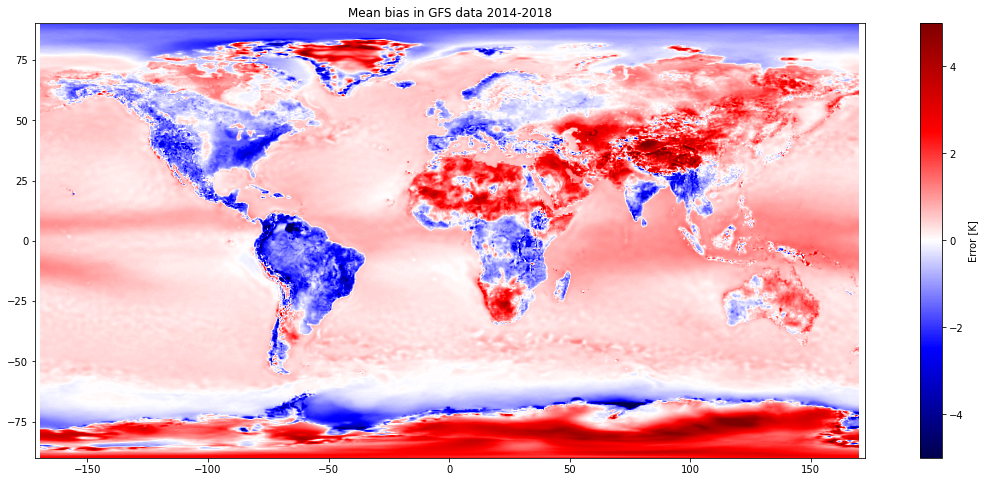

In [47]:
plt.figure(figsize = (20, 8))
plt.imshow(
    biasQuery.data['Expression-bias[bias]-Exp'],
    vmin = -5, vmax = 5, cmap = 'seismic',
    extent = [biasQuery.metadata['Expression-bias[bias]-Exp']['details']['boundingBox'][l] for l in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']]
)
plt.colorbar(label = 'Error [K]')
plt.title('Mean bias in GFS data 2014-2018')
plt.savefig('MeanBiasInGFS2014-2018.png', dpi = 60, bbox_inches = 'tight')
plt.show()

Having said that, it is instructive to look at the overall error distribution. Accumulating spatially leads to what is an essentially neglegible bias.

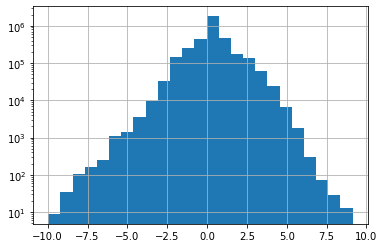

In [48]:
pd.Series(biasQuery.data['Expression-bias[bias]-Exp'].reshape(-1)).dropna().hist(bins = 25, log = True)
plt.show()

In [49]:
pd.Series(biasQuery.data['Expression-bias[bias]-Exp'].reshape(-1)).dropna().describe()

count    3.565530e+06
mean     3.581866e-01
std      1.139044e+00
min     -9.967070e+00
25%     -3.363000e-02
50%      3.527600e-01
75%      7.161000e-01
max      9.132940e+00
dtype: float64

Finally, we note an mean absolute error (MAE) of about 0.86 degrees Kelvin.

In [50]:
pd.Series(biasQuery.data['Expression-bias[bias]-Exp'].reshape(-1)).dropna().abs().mean()

0.8477787278696741

## Step 2b: Temporal dependence of the biases

One might ask whether the bias we identified in the previous query is a systematic bias or an artifact of the aggregation. So let us take a further look. The following query calculates the bias for each year in the 5-year period independently.

In [51]:
annualLayers = [
    [
    {
        'alias' : 'gfs_{}'.format(year),
        'type' : 'raster', 'id' : '50195', 'dimensions' : [{'name' : 'horizon', 'value' : '6'}],
        'aggregation' : 'Mean',
        'temporal' : {'intervals' : [{'snapshot' : ts.strftime(iso8601)} for _, ts in completeDates.iteritems() if ts.year == year]},
        'output' : False
    },
    {
        'alias' : 'era5_{}'.format(year),
        'type' : 'raster', 'id' : '49423', 'aggregation' : 'Mean',
        'temporal' : {'intervals' : [{'snapshot' : ts.strftime(iso8601)} for _, ts in completeDates.iteritems() if ts.year == year]},
        'output' : False
    },
    {
        'alias' : 'bias_{}'.format(year),
        'expression' : '$gfs_{year} - $era5_{year}'.format(year = year),
    }
    ] for year in range(2014, 2019)
]
annualLayers = [ll for l in annualLayers for ll in l]

annualBiasQueryJson = {
    'layers' : annualLayers,
    'spatial' : {'type' : 'square', 'coordinates' : ['-90', '-170', '90', '170']},
    'temporal' : {'intervals' : [{
        'start' : (datetime(2015, 1, 1) - timedelta(seconds = 1)).strftime(iso8601),
        'end' : datetime(2016, 1, 1).strftime(iso8601)
    }]}
}

In [52]:
annualBiasQuery = paw.PAIRSQuery(annualBiasQueryJson, auth=pairs_credentials, authType='api-key')
annualBiasQuery.submit()

In [66]:
annualBiasQuery.poll()
annualBiasQuery.queryStatus.json()['status']

'Succeeded'

In [67]:
annualBiasQuery.poll_till_finished()
annualBiasQuery.download()
annualBiasQuery.create_layers()

To keep the plot simple we only show data for 2014 - 2017. The situation is essentially the same for 2018.

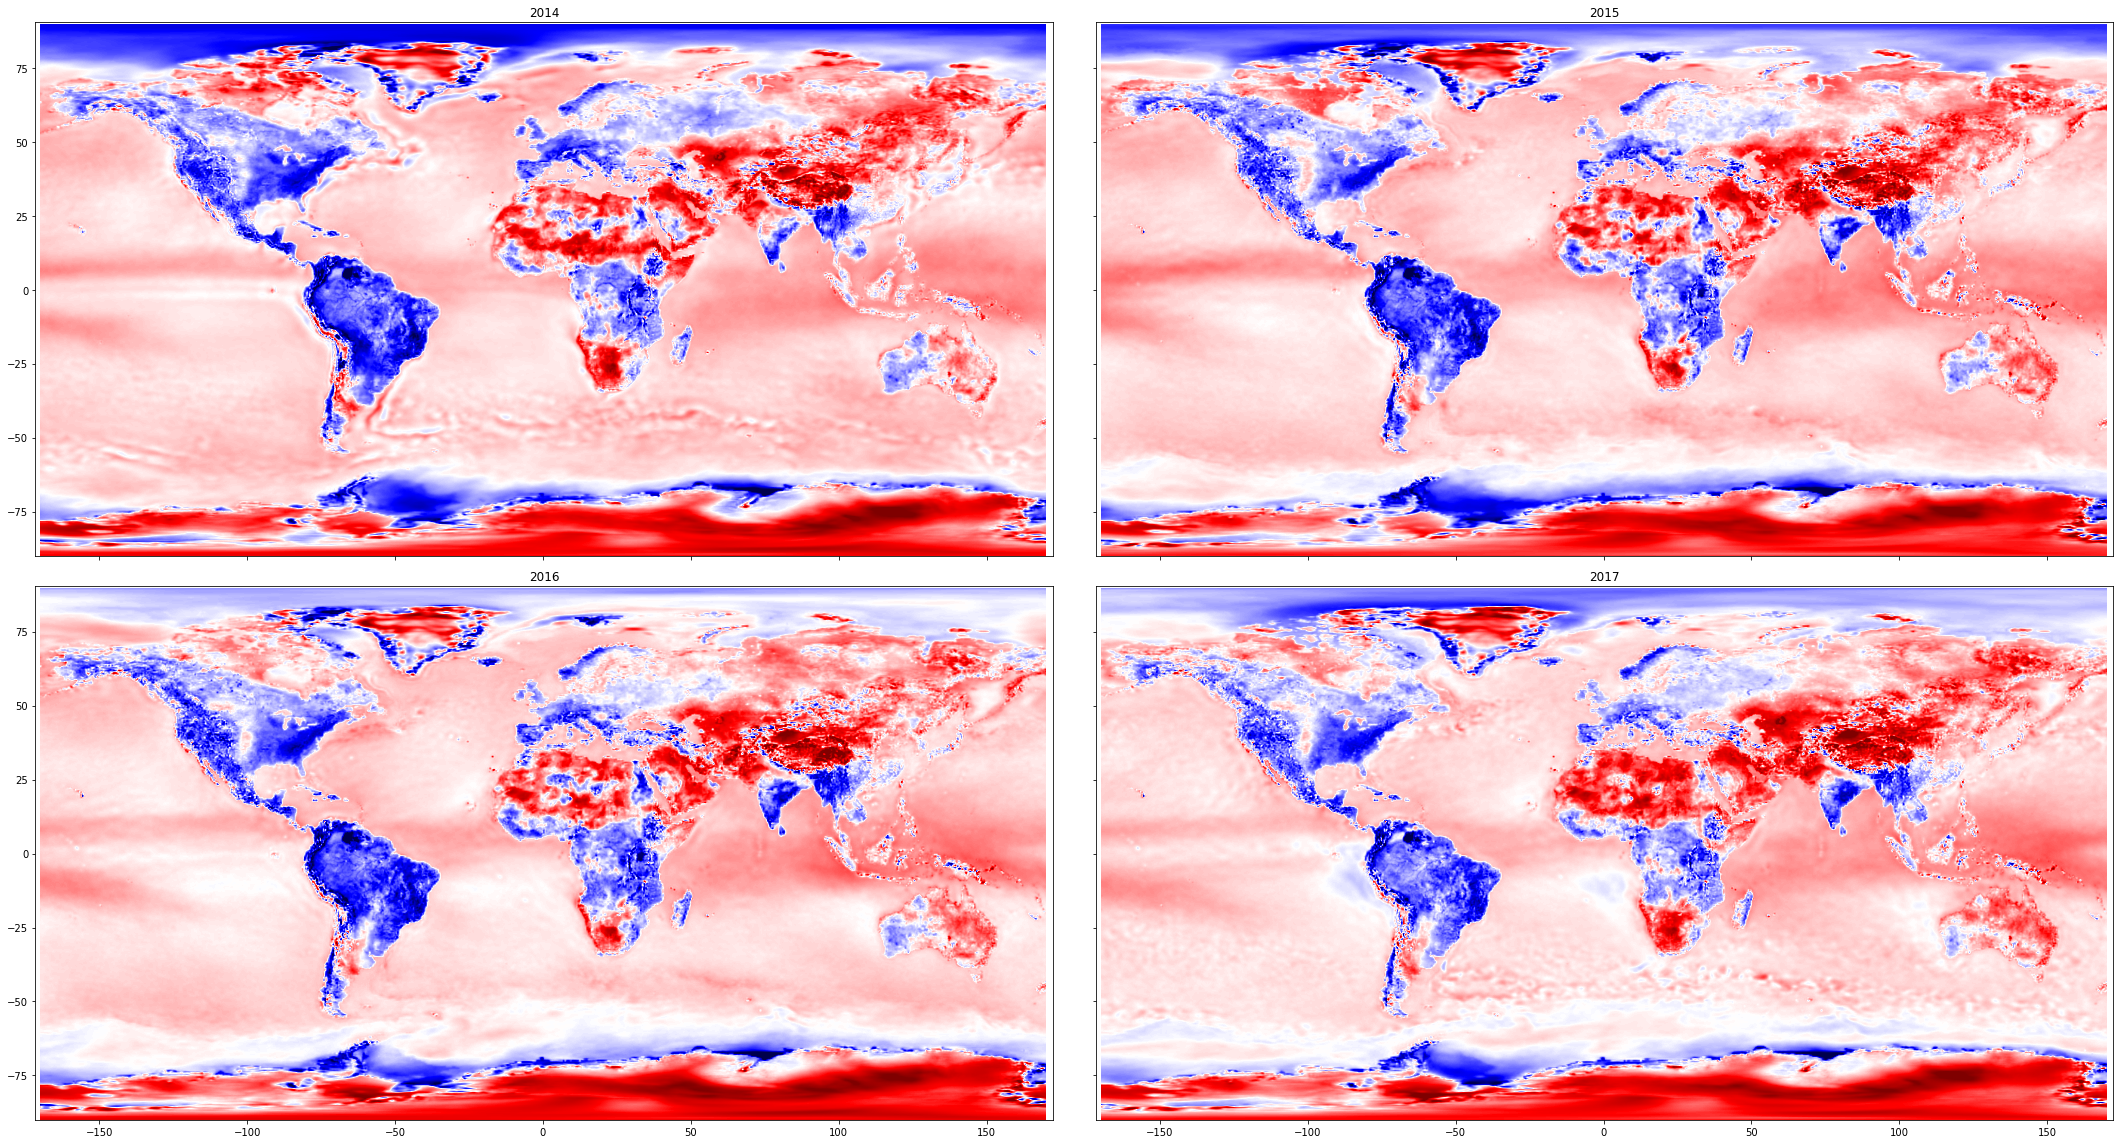

In [68]:
extent = extent = [annualBiasQuery.metadata['Expression-bias_2014[bias_2014]-Exp']['details']['boundingBox'][l] for l in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']]
fig, ax = plt.subplots(2, 2, figsize = (30, 16), sharex = True, sharey = True)
ax[0][0].imshow(annualBiasQuery.data['Expression-bias_2014[bias_2014]-Exp'], vmin = -5, vmax = 5, cmap = 'seismic', extent = extent)
ax[0][1].imshow(annualBiasQuery.data['Expression-bias_2015[bias_2015]-Exp'], vmin = -5, vmax = 5, cmap = 'seismic', extent = extent)
ax[1][0].imshow(annualBiasQuery.data['Expression-bias_2016[bias_2016]-Exp'], vmin = -5, vmax = 5, cmap = 'seismic', extent = extent)
ax[1][1].imshow(annualBiasQuery.data['Expression-bias_2017[bias_2017]-Exp'], vmin = -5, vmax = 5, cmap = 'seismic', extent = extent)
ax[0][0].set_title('2014')
ax[0][1].set_title('2015')
ax[1][0].set_title('2016')
ax[1][1].set_title('2017')
plt.tight_layout()
plt.savefig('TemporalDependenceOfBias.png', dpi = 60, bbox_inches = 'tight')
plt.show()

As we can see, the biases are fairly consistent with time. We see differences in the details between the above aggregation periods, but overall structures are the same. I.e. too low predictions in the Americas, Europe and at the North Pole, too high predictions in North and South Africa, Northern and Central Asia as well as Antarctica.

## Step 3: A bias corrected forecast

Having confirmed the existence of a bias, we can now issue a bias-corrected forecast for 2019. I.e. we use the bias measured during the previous 5-year period to shift the predictions for 2019. To start, we again make a point query to facilitat the temporal join.

In [28]:
pointQuery2019Json = {
    'layers' : [
        {
            'type' : 'raster', 'id' : '50195', 'dimensions' : [{'name' : 'horizon', 'value' : '6'}]
        },
        {
            'type' : 'raster', 'id' : '49423'
        }
    ],
    'spatial' : {'type' : 'point', 'coordinates' : ['40', '-100']},
    'temporal' : {'intervals' : [{
        'start' : (datetime(2019, 1, 1) - timedelta(seconds = 1)).strftime(iso8601),
        'end' : datetime(2019, 7, 1).strftime(iso8601)
    }]}
}

In [29]:
pointQuery2019 = paw.PAIRSQuery(pointQuery2019Json, auth=pairs_credentials, authType='api-key')
pointQuery2019.submit()
pointQuery2019.vdf['value'] = pd.to_numeric(pointQuery2019.vdf['value'])

In [30]:
completeDates2019 = pointQuery2019.vdf.pivot_table(index = 'timestamp', columns = 'layerId', values = 'value').dropna().index.to_series(keep_tz = True)

The following query again calculates the forecast bias of the years 2014-2018 and applies it to forecasts for the first half of 2019. Subsequently we calculate the bias of both the raw and bias-corrected 2019 forecasts.

In [31]:
biasCorrectedQueryJson = {
    'layers' : [
        {
            'alias' : 'historic_gfs',
            'type' : 'raster', 'id' : '50195', 'dimensions' : [{'name' : 'horizon', 'value' : '6'}],
            'aggregation' : 'Mean',
            'temporal' : {'intervals' : [{'snapshot' : ts.strftime(iso8601)} for _, ts in completeDates.iteritems()]},
            'output' : False
        },
        {
            'alias' : 'historic_era5',
            'type' : 'raster', 'id' : '49423', 'aggregation' : 'Mean',
            'temporal' : {'intervals' : [{'snapshot' : ts.strftime(iso8601)} for _, ts in completeDates.iteritems()]},
            'output' : False
        },
        {
            'alias' : 'gfs',
            'type' : 'raster', 'id' : '50195', 'dimensions' : [{'name' : 'horizon', 'value' : '6'}],
            'aggregation' : 'Mean',
            'temporal' : {'intervals' : [{'snapshot' : ts.strftime(iso8601)} for _, ts in completeDates2019.iteritems()]},
            'output' : False
        },
        {
            'alias' : 'era5',
            'type' : 'raster', 'id' : '49423', 'aggregation' : 'Mean',
            'temporal' : {'intervals' : [{'snapshot' : ts.strftime(iso8601)} for _, ts in completeDates2019.iteritems()]},
            'output' : False
        },
        {
            'alias' : 'bias',
            'expression' : '$gfs - $era5',
            'output' : True
        },
        {
            'alias' : 'bias_corrected_forecast',
            'expression' : '$gfs - $historic_gfs + $historic_era5',
            'output' : True
        },
        {
            'alias' : 'bias_of_bias_corrected_forecast',
            'expression' : '$gfs - $historic_gfs + $historic_era5 - $era5',
            'output' : True
        }
    ],
    'spatial' : {'type' : 'square', 'coordinates' : ['-90', '-170', '90', '170']},
    'temporal' : {'intervals' : [{
        'start' : (datetime(2015, 1, 1) - timedelta(seconds = 1)).strftime(iso8601),
        'end' : datetime(2016, 1, 1).strftime(iso8601)
    }]}
}

In [32]:
biasCorrectedQuery = paw.PAIRSQuery(biasCorrectedQueryJson, auth=pairs_credentials, authType='api-key')
biasCorrectedQuery.submit()

In [57]:
biasCorrectedQuery.poll_till_finished()
biasCorrectedQuery.download()
biasCorrectedQuery.create_layers()

## Step 4: Results

We can finally analyze the impact of the bias correction. To do so we both plot the spatial distribution of biases but also calculate a number of global metrics. To start, let's take a look at the spatial distribution.

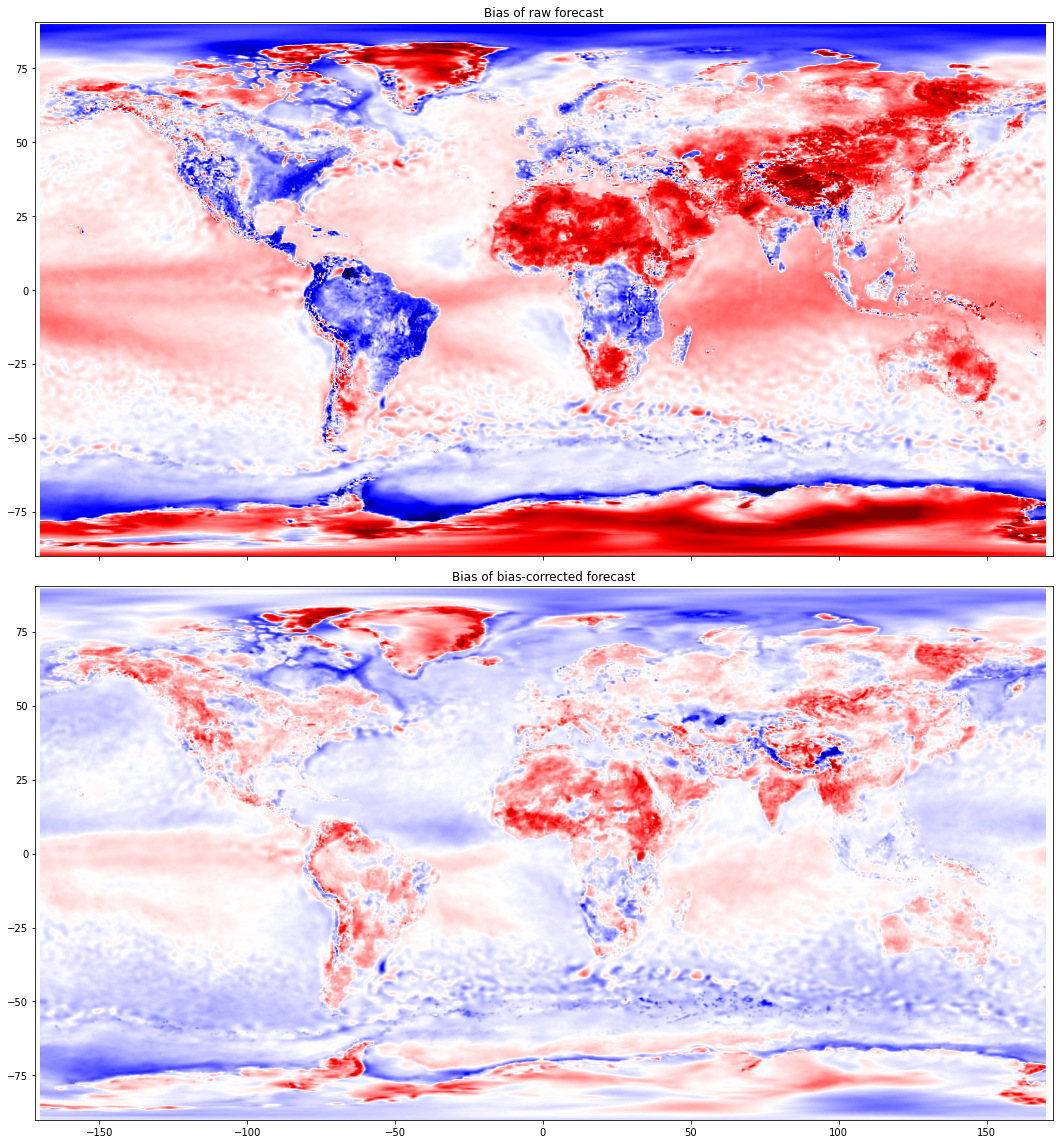

In [58]:
extent = extent = [biasCorrectedQuery.metadata['Expression-bias[bias]-Exp']['details']['boundingBox'][l] for l in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']]
fig, ax = plt.subplots(2, 1, figsize = (30, 16), sharex = True, sharey = True)
ax[0].imshow(
    biasCorrectedQuery.data['Expression-bias[bias]-Exp'], vmin = -5, vmax = 5, cmap = 'seismic', extent = extent
)
ax[1].imshow(
    biasCorrectedQuery.data['Expression-bias_of_bias_corrected_forecast[bias_of_bias_corrected_forecast]-Exp'], vmin = -5, vmax = 5, cmap = 'seismic', extent = extent
)
ax[0].set_title('Bias of raw forecast')
ax[1].set_title('Bias of bias-corrected forecast')
plt.tight_layout()
plt.savefig('PerformanceOfBiasCorrectedForecast.png', dpi = 60, bbox_inches = 'tight')
plt.show()

Since the two plots above are on the same color scale (see the use of `vmin` and `vmax`), we can make direct comparisons from the colors. Clearly, the bias corrected forecast shows an overall improvement. Note that the underprediction in the Americas, the Indian subcontinent and Europe has turned into an overprediction. The situation is somewhat more complicated in the rest of the world though.

To complement this impression we calculate some general metrics. Note that the mean absolute error (MAE) has improved quite significantly.

In [59]:
pd.DataFrame({
    'Raw forecast' : pd.Series(biasCorrectedQuery.data['Expression-bias[bias]-Exp'].reshape(-1)).dropna().describe().append(pd.Series({'MAE' : pd.Series(biasCorrectedQuery.data['Expression-bias[bias]-Exp'].reshape(-1)).dropna().abs().mean()})),
    'Bias-corrected forecast' : pd.Series(biasCorrectedQuery.data['Expression-bias_of_bias_corrected_forecast[bias_of_bias_corrected_forecast]-Exp'].reshape(-1)).dropna().describe().append(pd.Series({'MAE' : pd.Series(biasCorrectedQuery.data['Expression-bias_of_bias_corrected_forecast[bias_of_bias_corrected_forecast]-Exp'].reshape(-1)).dropna().abs().mean()}))
}).round(2)

,Raw forecast,Bias-corrected forecast
count,3565530.00,3565530.00
mean,0.28,-0.08
std,1.31,0.60
min,-10.47,-5.50
25%,-0.26,-0.39
50%,0.20,-0.13
75%,0.78,0.17
max,13.08,6.55
MAE,0.92,0.43
